In [1]:
import numpy as np
import tensorflow as tf
import os

from keras.utils import np_utils
import cv2
from matplotlib import pyplot as plt
#tf.enable_eager_execution()

Using TensorFlow backend.


In [0]:

(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [4]:
train_features.shape

(50000, 32, 32, 3)

In [0]:
def random_crop(input_image,padding_pixels=4,random_crop_size=(32,32)):
    assert input_image.shape[2]==3

    #pad for 4 pixels
    img = cv2.copyMakeBorder(input_image,padding_pixels,padding_pixels,padding_pixels,padding_pixels,cv2.BORDER_REPLICATE)
    height , width =img.shape[0],img.shape[1]
    dy,dx = random_crop_size
    x = np.random.randint(0,width - dx + 1)
    y = np.random.randint(0,height - dy + 1)
    return img[y:(y+dy),x:(x+dx),:]

#lambda_feat = lambda t : random_crop(t)
tr_seq = list(range(len(train_features)))
#te_seq = list(range(len(test_features)))
train_func = lambda i:random_crop(train_features[i])
train_features = list(map(train_func,tr_seq))

train_features = np.asarray(train_features)


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.3, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
x_train_mean = np.mean(train_features,axis=(0,1,2))
x_train_std = np.std(train_features,axis=(0,1,2))
x_test_mean = np.mean(test_features,axis=(0,1,2))
x_test_std = np.std(test_features,axis=(0,1,2))

In [0]:
train_features = (train_features-x_train_mean)/x_train_std
test_features = (test_features-x_test_mean)/x_test_std

In [0]:
datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=0.5,rotation_range=45,preprocessing_function=get_random_eraser())
# datagen_aug.mean = np.array(x_train_mean, dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
# datagen_aug.std = np.array(x_train_std, dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
datagen_aug.fit(train_features)
train_generator = datagen_aug.flow(train_features,train_labels,batch_size=256)



In [0]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_datagen.fit(test_features)
test_generator = test_datagen.flow(test_features,test_labels,batch_size=128)

In [0]:
# aug_img=np.zeros((256,32,32,3))
# train_gen = train_generator.next()
# aug_img[:256]= train_gen[0]

In [13]:
import h5py
f = h5py.File('aug_img.hdf5', 'w')
d = f.create_dataset('dataset', (1200000,32,32,3),chunks=(256,32,32,3))
l = f.create_dataset('labels',(1200000,10),chunks=(256,10))


batch_size=256
EPOCHS =24
aug_lbl=[]
tmp=0
for i in range(EPOCHS):
  print("tmp ", tmp)
  for j in range(len(train_generator)):
    initial = j*batch_size+tmp
    train_gen = train_generator.next()
    if(j == 195 ):
      final += 80
      d[initial:final]= train_gen[0]
      l[initial:final]= train_gen[1]
      continue 
      
    
    final = initial + 256
    d[initial:final]= train_gen[0]
    l[initial:final]= train_gen[1]
  
  tmp = final

# f.close()

  
  

OSError: ignored

#Resnet Model Creation

In [0]:
import time, math
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

#initializer = tf.keras.initializers.glorot_normal(seed=None)

In [0]:
from tensorflow.keras import regularizers
def ResNetBlock(input_layer, channels,stride=1):
  
  bn_1 = tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)(input_layer)
  activation_layer_b1 = tf.keras.layers.Activation('relu')(bn_1)
  if(stride==2):
    block_layer_1 = tf.keras.layers.Conv2D(channels, (3,3) ,padding='same',kernel_initializer=init_pytorch,use_bias=False,
                                           kernel_regularizer=regularizers.l2(0.005))(activation_layer_b1)
    block_layer_1= tf.keras.layers.MaxPooling2D()(block_layer_1)
  else:
    block_layer_1 = tf.keras.layers.Conv2D(channels, (3,3), padding='same',kernel_initializer=init_pytorch,use_bias=False,
                                           kernel_regularizer=regularizers.l2(0.005))(activation_layer_b1)
  
#   bn_2 = tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)(block_layer_1)
#   activation_layer_b1 = tf.keras.layers.Activation('relu')(bn_1)
  #one_layer = tf.keras.layers.Conv2D(channels-(channels//2), (1, 1), padding='same')(block_layer_1)
  #drp_r = tf.keras.layers.SpatialDropout2D(0.05)(block_layer_1)
  
  bn_2 = tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)(block_layer_1)
  activation_layer_b2 = tf.keras.layers.Activation('relu')(bn_2) 
  block_layer_2 = tf.keras.layers.Conv2D(channels, (3,3), padding='same',kernel_initializer=init_pytorch,use_bias=False,kernel_regularizer=regularizers.l2(0.005))(activation_layer_b2)
   
  
  return block_layer_2
  

In [16]:
# from tf.keras.layers import Input, add, GlobalAveragePooling2D, Dense
#from tf.keras.models import Model

inputs = tf.keras.layers.Input(shape=(32, 32, 3))

x1 = tf.keras.layers.Conv2D(32, (3, 3),padding='same',kernel_initializer=init_pytorch,use_bias=False,kernel_regularizer=regularizers.l2(0.01))(inputs)   #32x32 
activation_x1 = tf.keras.layers.Activation('relu')(x1)
bn1 = tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)(activation_x1)

# x2 = tf.keras.layers.Conv2D(64, (3, 3),padding='same',kernel_initializer=initializer)(bn1)   #32x32 
# activation_x2 = tf.keras.layers.Activation('relu')(x2)
# bn2 = tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)(activation_x2)

# x3 = tf.keras.layers.Conv2D(64, (3, 3),padding='same')(activation_x2)   #32x32 
# activation_x3 = tf.keras.layers.Activation('relu')(x3)
# bn3 = tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)(activation_x3)

# mx_p= tf.keras.layers.MaxPooling2D()(bn1)



##block 1

blk1 = ResNetBlock(bn1,32,stride=2)  ##32x32
mxp_1 = tf.keras.layers.MaxPooling2D()(bn1)
#one_blk_1 = tf.keras.layers.Conv2D(32, (1, 1), padding='same',strides=2)(bn1)
z1 = tf.keras.layers.add([blk1,mxp_1])

blk1_c = ResNetBlock(z1,32)
z1_c = tf.keras.layers.add([blk1_c,z1])

drp_1 = tf.keras.layers.SpatialDropout2D(0.05)(z1_c)


##block 2

blk2 = ResNetBlock(drp_1,64)
one_blk = tf.keras.layers.Conv2D(64, (1, 1), padding='same')(drp_1)
z2 = tf.keras.layers.add([blk2,one_blk])

blk2_c = ResNetBlock(z2,64)
z2_c = tf.keras.layers.add([blk2_c,z2])


drp_2 = tf.keras.layers.SpatialDropout2D(0.05)(z2_c)

##block3

blk3 = ResNetBlock(drp_2,128,stride=2)

one_blk_1 = tf.keras.layers.Conv2D(128,(1, 1), padding='same')(drp_2)
mxp_2 = tf.keras.layers.MaxPooling2D()(one_blk_1)


z3 = tf.keras.layers.add([blk3,mxp_2])

blk3_c = ResNetBlock(z3,128)
z3_c = tf.keras.layers.add([blk3_c,z3])


drp_3 = tf.keras.layers.Dropout(0.05)(z3_c)
#block4

blk4 = ResNetBlock(drp_3,256,stride=2)

one_blk_2 = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(drp_3)
mxp_3 = tf.keras.layers.MaxPooling2D()(one_blk_2)

z4 = tf.keras.layers.add([blk4,mxp_3])

blk4_c = ResNetBlock(z4,256)
z4_c = tf.keras.layers.add([blk4_c,z4])
# drp_4 = tf.keras.layers.Dropout(0.05)(z4_c)

# #block5
# blk5 = ResNetBlock(drp_4,128,stride=2)
# one_blk_3 = tf.keras.layers.Conv2D(128, (1, 1), padding='same',strides=2)(drp_4)
# z5 = tf.keras.layers.add([blk5,one_blk_3])

# blk5_c = ResNetBlock(z5,128)
# z5_c = tf.keras.layers.add([blk5_c,z5])



avg_pool_layer = tf.keras.layers.GlobalAveragePooling2D()(z4_c)


fc_layer = tf.keras.layers.Dense(10, activation='softmax')(avg_pool_layer)


model = tf.keras.models.Model(inputs=inputs, outputs= fc_layer)


W0817 07:52:26.103640 140369041852288 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         activation[0][0]                 
______________________________________________________________________________________________

#Best LR would be 0.01

In [0]:
# for 24 epochs only

MAX_LR= 0.15
base_lr = 0.015

def lr_func(epoch,lr):
  lr = base_lr
  #print("lwr",tf.train.get_or_create_global_step())
  max_lr = MAX_LR
  
  if(epoch == 0):
    lr = base_lr
  elif(epoch>0 and epoch<5):
    lr += (max_lr-base_lr)*(epoch)/5
  else:
    lr = max_lr - (max_lr-base_lr)*(epoch-5)/18
  print("final lr ",round(lr,5))
  

  return round(lr,5)
  

In [0]:
!ls

aug_img.hdf5  sample_data


In [0]:
data = tf.keras.utils.HDF5Matrix('./aug_img.hdf5','dataset')
label = tf.keras.utils.HDF5Matrix('./aug_img.hdf5','labels')

In [0]:
##from HDF5 ---
import random

train_data_aug_l = lambda i: (np.array(data[i:i+168]),np.array(label[i:i+168]))
train_data_wo_l = lambda i: (np.array(train_features[i:i+168]),np.array(train_labels[i:i+168]))

train_data_aug = lambda i: (np.array(data[i:i+256]),np.array(label[i:i+256]))
train_data_wo = lambda i: (np.array(train_features[i:i+256]),np.array(train_labels[i:i+256]))

num_seq = list(range(len(train_features)//512+1))


def data_generator():
  
  train_data= np.zeros(shape=(50000,32,32,3))
  train_lbl = np.zeros(shape=(50000,10))
  
  
  tmp=0
  for k in num_seq:
    aug_ran = random.randrange(0,len(data)-256)
    wo_aug = random.randrange(0,len(train_features)-256)

    inital=tmp
    if(k == 97):
      final = inital+336
      train_data[inital:final] = np.concatenate((train_data_aug_l(aug_ran)[0],train_data_wo_l(wo_aug)[0]),axis=0)
      train_lbl[inital:final] = np.concatenate((train_data_aug_l(aug_ran)[1],train_data_wo_l(wo_aug)[1]),axis=0)
    else:
      final  = inital+512
      train_data[inital:final] = np.concatenate((train_data_aug(aug_ran)[0],train_data_wo(wo_aug)[0]),axis=0)
      train_lbl[inital:final] = np.concatenate((train_data_aug(aug_ran)[1],train_data_wo(wo_aug)[1]),axis=0)

    tmp += 512
  
  return train_data,train_lbl
  
  


In [0]:
x,y = data_generator()

W0816 14:04:21.560283 140433647257472 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

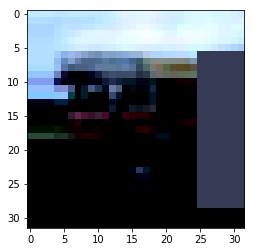

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
plt.imshow(x[4])
y[4]
#x.shape

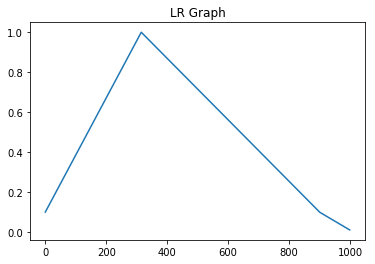

In [19]:

def min_max_scaler(iterations, num_iterations, end_percentage, min_val, max_val, invert = False, triangle_tilt = 0.7):
  non_slant_mid_cycle_id = int(num_iterations * ((1. - end_percentage)) / float(2))
  mid_cycle_id = int(triangle_tilt*int(num_iterations * ((1. - end_percentage)) / float(2)))
  value = 0
  if iterations > 2 * non_slant_mid_cycle_id:
    
    
      extra_iters = (iterations - 2 * non_slant_mid_cycle_id)
      current_percentage = 1 - (1 - 1/10)*extra_iters/(num_iterations - 2 * non_slant_mid_cycle_id)
            

  elif iterations >  mid_cycle_id:
      current_percentage = 1. - (iterations - mid_cycle_id) / (2*non_slant_mid_cycle_id - mid_cycle_id)
      
  else:
      current_percentage = iterations / mid_cycle_id
      
  if invert:
    if iterations > 2 * non_slant_mid_cycle_id:
      return max_val
    return max_val - current_percentage * (max_val - min_val)
  else:
    if iterations > 2 * non_slant_mid_cycle_id:
      return min_val * current_percentage
    return min_val + current_percentage * (max_val - min_val)
  
    

print("="*80)
scales = []
for i in range(1000):
  p = min_max_scaler(i,1000,0.1,min_val=0.1,max_val=1, invert=False,)
  scales.append(p)
  
plt.plot(np.array(scales))
plt.title("LR Graph")
plt.show()

In [0]:
import os
import numpy as np
import warnings

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K


class OneCycleLR(Callback):
    def __init__(self,
                 epochs,
                 batch_size,
                 samples,
                 steps,
                 max_lr,
                 end_percentage=0.1,
                 scale=100,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 triangle_tilt = 0.75,
                 verbose=True):
        
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")


        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = scale
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = epochs
        self.batch_size = batch_size
        self.samples = samples
        self.triangle_tilt=triangle_tilt
        self.steps = None
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        
        new_lr = min_max_scaler(self.clr_iterations, self.num_iterations, self.end_percentage, self.initial_lr/self.scale, self.initial_lr, invert = False, triangle_tilt=self.triangle_tilt)
        return new_lr

    def compute_momentum(self):
         
        new_momentum = min_max_scaler(self.clr_iterations, self.num_iterations, self.end_percentage, self.min_momentum, self.max_momentum, invert = True, triangle_tilt=self.triangle_tilt)
        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))
                
    
    def plot(self):
        plt.title("LR-Plot")
        plt.plot(self.history['lr'])
        plt.xlabel("Epochs")
        plt.ylabel("LR")
        plt.show()
        
        plt.title("Momentum-Plot")
        plt.plot(self.history['momentum'])
        plt.xlabel("Epochs")
        plt.ylabel("Momentum")
        plt.show()

In [0]:
opt = tf.keras.optimizers.SGD(nesterov=True)
model.compile(optimizer=opt , loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# filepath = "Resnet-13-test1.hdf5"
# from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler

# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# tmp_gen = tf.keras.preprocessing.image.ImageDataGenerator()

# ##Train the model
# # model_info = model.fit_generator(train_generator,
# #                                  steps_per_epoch=np.ceil(50000/128), epochs=24,  
# #                                  validation_data = test_generator, verbose=1,callbacks=[checkpoint,LearningRateScheduler(lr_func, verbose=1)])

# EPOCHS=24
# for i in range(EPOCHS): 
#   X_train,X_label = data_generator()
#   model.fit(X_train,X_label,batch_size=512,
#                                epochs=1,validation_data=(test_features,test_labels),
#                          callbacks=[LearningRateScheduler(lr_func, verbose=1)]
 #          )

In [0]:
import numpy as np
import keras
import random
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, label, train_features,train_labels, batch_size=32, dim=(32,32), n_channels=3,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.label = label
        self.data = data
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.train_features = train_features
        self.train_labels = train_labels
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        # Generate indexes of the batch
        #indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        aug_ran = random.randrange(0,len(self.data)-256)
        wo_aug = random.randrange(0,len(self.train_features)-256)
        #print(aug_ran)
        train_data_aug = lambda i: (np.array(self.data[i:i+64]),np.array(self.label[i:i+64]))
        train_data_wo = lambda i: (np.array(self.train_features[i:i+64]),np.array(self.train_labels[i:i+64]))
        
        
        X = np.concatenate((train_data_aug(aug_ran)[0],train_data_wo(wo_aug)[0]),axis=0)
        y = np.concatenate((train_data_aug(aug_ran)[1],train_data_wo(wo_aug)[1]),axis=0)
        #print("label",y.shape, " " ,X.shape)
        #plt.imshow(X[0])
        # Generate data
        #X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)



In [0]:
gen = DataGenerator(data,label,train_features,train_labels,128)


In [0]:
olr = OneCycleLR(epochs=24,
                 batch_size=128,
                 samples=50000,steps=None,
                 max_lr=0.2,triangle_tilt=0.7)

W0817 07:52:54.207176 140369041852288 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


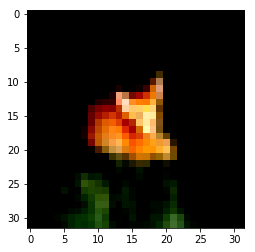

In [25]:
x,y = test_generator.next()
plt.imshow(x[76])

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
model.fit_generator(generator=gen,steps_per_epoch=np.ceil(50000/128), epochs=24,  
                                validation_data = test_generator, verbose=1,callbacks =[olr])

Epoch 1/24
391/391 [==============================] - 25s 64ms/step - loss: 5.5313 - acc: 0.1668 - val_loss: 4.9457 - val_acc: 0.2389
Epoch 2/24
391/391 [==============================] - 20s 51ms/step - loss: 4.4653 - acc: 0.3026 - val_loss: 3.8819 - val_acc: 0.3524
Epoch 3/24
391/391 [==============================] - 20s 51ms/step - loss: 3.4085 - acc: 0.4018 - val_loss: 3.0434 - val_acc: 0.4123
Epoch 4/24
391/391 [==============================] - 20s 52ms/step - loss: 2.5279 - acc: 0.4810 - val_loss: 2.9935 - val_acc: 0.3070
Epoch 5/24
391/391 [==============================] - 20s 52ms/step - loss: 1.9953 - acc: 0.5256 - val_loss: 2.3015 - val_acc: 0.4295
Epoch 6/24
391/391 [==============================] - 20s 52ms/step - loss: 1.7520 - acc: 0.5477 - val_loss: 1.7290 - val_acc: 0.5519
Epoch 7/24
391/391 [==============================] - 20s 52ms/step - loss: 1.6922 - acc: 0.5534 - val_loss: 1.9811 - val_acc: 0.5067
Epoch 8/24
391/391 [==============================] - 20s 52ms